In [115]:
from Bio import SeqIO
import pandas as pd

def read_fasta_with_labels(file_path):
    data = []
    
    for record in SeqIO.parse(file_path, "fasta"):
        protein_id = record.id

        sequence = str(record.seq)

        label = 0 if "non-allergen" in protein_id else 1
        
        data.append([protein_id, sequence, label])

    df = pd.DataFrame(data, columns=["Protein_ID", "Sequence", "Label"])
    
    return df

In [116]:
train_df = read_fasta_with_labels("Dataset/all.train.fasta")
test_df = read_fasta_with_labels("Dataset/all.test.fasta")

In [117]:
print(train_df.head())

           Protein_ID                                           Sequence   
0   non-allergen_3154  MAAHTILASAPSHTTFSLISPFSSTPTNALSSSLQSSSFNGLSFKL...  \
1   non-allergen_2914  MAQFLRLCIWLLALGSCLLATVQADCSQDCAKCSYRLVRPGDINFL...   
2  non-allergen_19622  MSSTTQAPEPVYQWTADEAVQFLKEWNFSLGIILLFITIILQFGYT...   
3       allergen_2182  MSWQAYVDDHLMCEIEGTNNHLTAAAILGVDGSVWAQSANFPQFKP...   
4  non-allergen_40251  MNLFVYIAQNPTLTKWFFCCVCTILTMPFFKKPYRKRGISRTPYEW...   

   Label  
0      0  
1      0  
2      0  
3      1  
4      0  


In [101]:
train_df.columns

Index(['Protein_ID', 'Sequence', 'Label'], dtype='object')

In [102]:
train_df['Protein_ID']

0        non-allergen_3154
1        non-allergen_2914
2       non-allergen_19622
3            allergen_2182
4       non-allergen_40251
               ...        
5675         allergen_1982
5676          allergen_271
5677         allergen_1245
5678          allergen_738
5679         allergen_3361
Name: Protein_ID, Length: 5680, dtype: object

In [103]:
len(train_df), len(test_df)

(5680, 1420)

In [104]:
test_df.columns

Index(['Protein_ID', 'Sequence', 'Label'], dtype='object')

In [15]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")
model = model.eval()  # Inference mode

In [16]:
def embed_sequence(sequence, tokenizer, model):
    # Format sequence for ProtBERT: space-separated residues
    sequence = " ".join(list(sequence))
    sequence = sequence.replace("U", "X").replace("Z", "X").replace("O", "X")  # Unknown tokens handled

    # Tokenize and get embeddings
    inputs = tokenizer(sequence, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract last hidden state (batch_size, seq_len, hidden_dim)
    embeddings = outputs.last_hidden_state.squeeze(0)  # remove batch dimension

    # Remove special tokens ([CLS] at 0 and [SEP] at end)
    residue_embeddings = embeddings[1:-1]

    return residue_embeddings  # shape: (num_residues, 1024)

In [17]:
train_embeddings = {}
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    pid = row["Protein_ID"]
    seq = row["Sequence"]
    emb = embed_sequence(seq, tokenizer, model)  # shape: (residues, 1024)
    train_embeddings[pid] = emb.cpu()

100%|██████████| 5680/5680 [31:42<00:00,  2.98it/s] 


In [18]:
torch.save(train_embeddings, "train_protbert_embeddings.pt")

In [26]:
train_embeddings[pid]

tensor([[ 0.0247,  0.1099, -0.1631,  ...,  0.0369,  0.0702, -0.1104],
        [-0.0443,  0.0700,  0.0118,  ..., -0.0112,  0.0490,  0.0697],
        [-0.0143,  0.1544,  0.0213,  ...,  0.0672,  0.0599,  0.1342],
        ...,
        [ 0.0315, -0.0147, -0.0767,  ..., -0.0694,  0.0390,  0.0495],
        [-0.0189, -0.0380, -0.0264,  ...,  0.0220, -0.0511, -0.0195],
        [-0.0910, -0.0576, -0.0677,  ..., -0.0404,  0.0442,  0.0431]])

In [19]:
for pid, row in train_df.iterrows():
    seq_len = len(row["Sequence"])
    emb = train_embeddings[row["Protein_ID"]]
    if emb.shape[0] != seq_len:
        print(f"Mismatch: {row['Protein_ID']} | Seq len: {seq_len} | Emb len: {emb.shape[0]}")

In [20]:
for pid, emb in train_embeddings.items():
    if torch.isnan(emb).any():
        print(f"NaNs found in {pid}")
    if torch.abs(emb).max() > 1e3:  
        print(f"Abnormal values in {pid}")

In [30]:
protein_id = "non-allergen_28864"

embeddings = train_embeddings[protein_id] 
print(f"Embeddings for Protein ID: {protein_id}\n")

sequence = train_df.set_index("Protein_ID").loc[protein_id]["Sequence"]

for i, (residue, emb) in enumerate(zip(sequence, embeddings)):
    print(f"Residue {i+1} ({residue}):")
    print(f"Embedding: {emb.numpy()}") 
    print("-" * 60)

Embeddings for Protein ID: non-allergen_28864

Residue 1 (M):
Embedding: [ 0.15589932  0.07994801  0.01546223 ... -0.11410765  0.04904244
 -0.12837271]
------------------------------------------------------------
Residue 2 (D):
Embedding: [ 0.19869553  0.03027831  0.0220241  ... -0.2512436   0.02347161
 -0.00108215]
------------------------------------------------------------
Residue 3 (P):
Embedding: [-0.02447848 -0.00519054 -0.11727352 ... -0.18212542  0.09420467
  0.07839175]
------------------------------------------------------------
Residue 4 (Q):
Embedding: [ 0.04977367  0.11809993 -0.05604193 ... -0.12280145 -0.03835776
  0.01646469]
------------------------------------------------------------
Residue 5 (N):
Embedding: [ 0.04005463  0.063382   -0.03946394 ... -0.07743031  0.05484409
  0.00284598]
------------------------------------------------------------
Residue 6 (A):
Embedding: [ 0.05279265  0.1042033   0.00854377 ... -0.10919717  0.0579971
  0.04196295]
-------------------

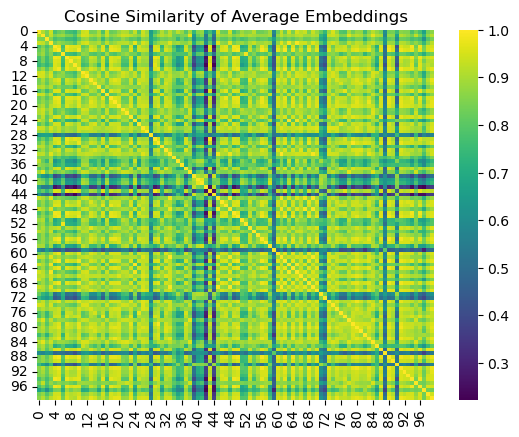

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt


def average_embedding(emb):
    return emb.mean(dim=0).numpy()

ids = list(train_embeddings.keys())[:100]  # subset for speed
avg_embs = [average_embedding(train_embeddings[pid]) for pid in ids]
similarities = cosine_similarity(avg_embs)


sns.heatmap(similarities, cmap="viridis")
plt.title("Cosine Similarity of Average Embeddings")
plt.show()

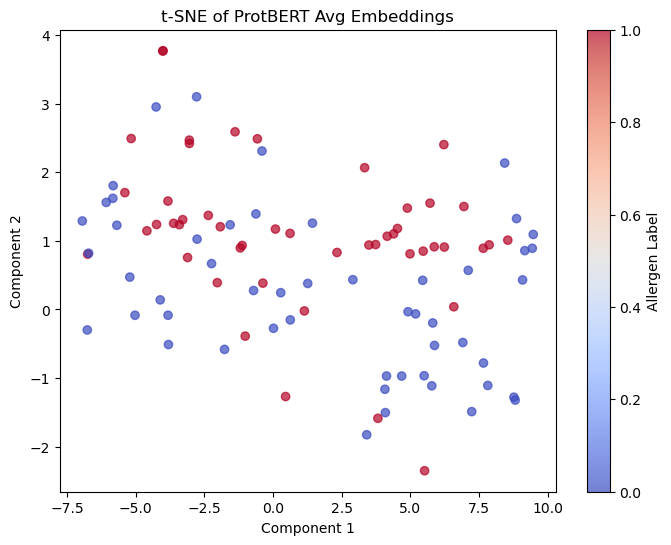

In [27]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

avg_embs = np.array(avg_embs)

labels = train_df.set_index("Protein_ID").loc[ids]["Label"].values  # allergen = 1, non-allergen = 0

tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(avg_embs)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.title("t-SNE of ProtBERT Avg Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Allergen Label")
plt.show()


In [28]:
test_embeddings = {}
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    pid = row["Protein_ID"]
    seq = row["Sequence"]
    emb = embed_sequence(seq, tokenizer, model)
    test_embeddings[pid] = emb.cpu()

100%|██████████| 1420/1420 [08:16<00:00,  2.86it/s]


In [31]:
torch.save(test_embeddings, "test_protbert_embeddings.pt")

In [32]:
for pid, row in test_df.iterrows():
    seq_len = len(row["Sequence"])
    emb = test_embeddings[row["Protein_ID"]]
    if emb.shape[0] != seq_len:
        print(f"Mismatch: {row['Protein_ID']} | Seq len: {seq_len} | Emb len: {emb.shape[0]}")

In [33]:
for pid, emb in test_embeddings.items():
    if torch.isnan(emb).any():
        print(f"NaNs found in {pid}")
    if torch.abs(emb).max() > 1e3:  
        print(f"Abnormal values in {pid}")

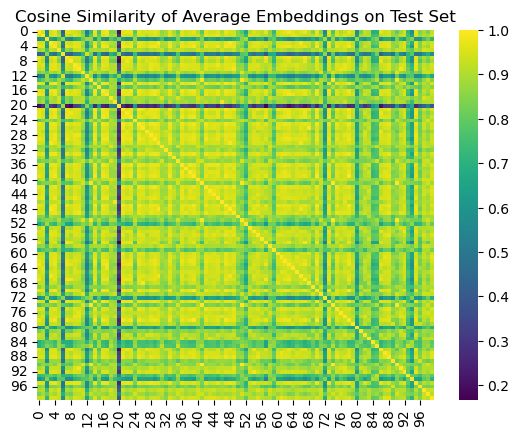

In [34]:
ids = list(test_embeddings.keys())[:100]  # subset for speed
avg_embs = [average_embedding(test_embeddings[pid]) for pid in ids]
similarities = cosine_similarity(avg_embs)


sns.heatmap(similarities, cmap="viridis")
plt.title("Cosine Similarity of Average Embeddings on Test Set")
plt.show()

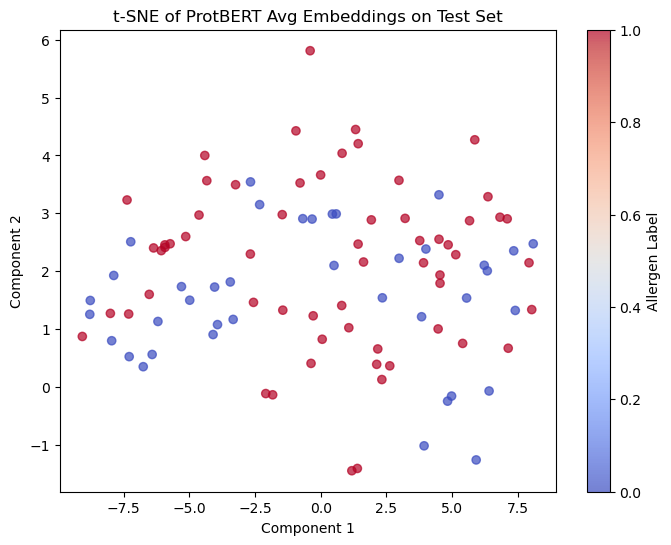

In [35]:
avg_embs = np.array(avg_embs)

labels = test_df.set_index("Protein_ID").loc[ids]["Label"].values  # allergen = 1, non-allergen = 0

tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(avg_embs)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.title("t-SNE of ProtBERT Avg Embeddings on Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Allergen Label")
plt.show()

This part of the code is used for extracting the 3D coordinates of the alpha carbon (Cα) atoms from a PDB file. It works by reading the PDB file, parsing its structure, and then extracting the Cα atom coordinates, which are essential for representing the protein's 3D structure in a graph-based model.

In [36]:
import torch
import numpy as np
from torch_geometric.data import Data
from Bio.PDB import PDBParser

def extract_ca_coords(pdb_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    ca_coords = []

    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_coords.append(residue['CA'].get_coord())

    return np.array(ca_coords)  # shape: (L, 3) --> (x, y, z) coordinates of CA atoms

Each graph represents one protein with 
* nodes --> amino acid residues
* node features --> ProtBERT embeddings per residue
* edges --> connections between residues based on sequence and 3D structure
* edge weights --> None (default is unweighted) for GraphSAGE
* Label = Allergenicity of the full protein (binary classification) allergen/not allerge

* If a protein has 100 resiudes, graph will have 100 nodes
* Each node (residue) has a feature vector of size 1024, extracted from ProtBERT.
* Node i has x[i] = ProtBERT embedding for residue i
* Sequence: connect i–i+1
* Spatial: connect i–j if distance ≤ 8Å


* Amino acid residues connected each other if they are consecutive in the sequence
* There are also AlphaFold structure edges with Residues i ↔ j if dist ≤ 8Å

In [144]:
import torch
import numpy as np
import networkx as nx
from Bio.PDB import PDBParser
from scipy.spatial.distance import cosine

def load_embeddings(embedding_file_path):
    embeddings = torch.load(embedding_file_path)  # dictionary containing embeddings
    return embeddings


In [125]:
test_embeddings["allergen_1399"]

tensor([[ 0.2207,  0.0437, -0.0807,  ..., -0.0227, -0.0386, -0.0701],
        [ 0.2531, -0.0914, -0.0796,  ..., -0.0458, -0.0194, -0.2150],
        [ 0.1900, -0.1402,  0.0138,  ..., -0.0653,  0.1359, -0.0209],
        ...,
        [-0.0279,  0.1154,  0.0772,  ..., -0.0306, -0.0079,  0.1426],
        [ 0.2251,  0.0270, -0.1334,  ..., -0.2172, -0.1079,  0.0087],
        [ 0.0869,  0.0820,  0.0349,  ..., -0.2467, -0.1908,  0.0333]])

In [135]:
test_df.head()

,Protein_ID,Sequence,Label
0,allergen_2145,MVKNLPPSVREQCIESQIVIRDCEEKKYGENCAELIKQCVTITGAP...,1
1,allergen_109,MKFFAVLALCIVGAIASPLTADEASLVQSSWKAVSHNEVEILAAVF...,1
2,allergen_2419,MSKARVYTDVNVLRPKEYWDYEALTVQWGEQDDYEVVRKVGRGKYS...,1
3,allergen_12,MAKLVLSLCFLLFSGCCFAFSFREQPQQNECQIQRLNALKPDNRIE...,1
4,allergen_117,MKIVLAIASLLALSAVYARPSSIKTFEEYKKAFNKSYATFEDEEAA...,1


In [106]:
test_df['Protein_ID'].values[:5]

array(['allergen_2145', 'allergen_109', 'allergen_2419', 'allergen_12',
       'allergen_117'], dtype=object)

In [ ]:
protein_id_to_check = "allergen_1399"

if protein_id_to_check in test_df['Protein_ID'].values:
    print(f"Protein ID {protein_id_to_check} found in test_df.")
else:
    print(f"Protein ID {protein_id_to_check} not found in test_df.")

Protein ID allergen_1399 found in test_df.


In [108]:
print(test_df.columns)

Index(['Protein_ID', 'Sequence', 'Label'], dtype='object')


In [109]:
if 'Protein_ID' in test_df.columns:
    test_df.set_index('Protein_ID', inplace=True)
    print(test_df.index)
else:
    print("Protein_ID column not found!")

Index(['allergen_2145', 'allergen_109', 'allergen_2419', 'allergen_12',
       'allergen_117', 'non-allergen_30176', 'non-allergen_4723',
       'non-allergen_20342', 'allergen_829', 'non-allergen_28719',
       ...
       'allergen_1150', 'allergen_3283', 'allergen_658', 'allergen_2409',
       'non-allergen_23633', 'allergen_606', 'non-allergen_4950',
       'allergen_3202', 'allergen_2761', 'allergen_2771'],
      dtype='object', name='Protein_ID', length=1420)


In [110]:
print(test_df.head())

                                                        Sequence  Label
Protein_ID                                                             
allergen_2145  MVKNLPPSVREQCIESQIVIRDCEEKKYGENCAELIKQCVTITGAP...      1
allergen_109   MKFFAVLALCIVGAIASPLTADEASLVQSSWKAVSHNEVEILAAVF...      1
allergen_2419  MSKARVYTDVNVLRPKEYWDYEALTVQWGEQDDYEVVRKVGRGKYS...      1
allergen_12    MAKLVLSLCFLLFSGCCFAFSFREQPQQNECQIQRLNALKPDNRIE...      1
allergen_117   MKIVLAIASLLALSAVYARPSSIKTFEEYKKAFNKSYATFEDEEAA...      1


In [111]:
from Bio.PDB import PDBParser

def check_missing_ca_atoms(pdb_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    
    missing_residues = []
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' not in residue:
                    missing_residues.append(residue.get_id()[1])  
    
    return missing_residues

pdb_file = "/Users/beyzakaya/Desktop/proteinAllergen/example_pdb_files/allergen_1399_unrelaxed_rank_002_alphafold2_ptm_model_4_seed_000.pdb"
missing_residues = check_missing_ca_atoms(pdb_file)
print(f"Missing Cα atoms for residues: {missing_residues}")

Missing Cα atoms for residues: []
